In [1]:
import numpy as np
import pandas as pd
import re
from prettytable import PrettyTable
from matplotlib import pyplot as plt
from scipy.stats import chi2, t, f
from math import pi
%matplotlib inline

In [2]:
def DW(res):
    return np.sum((res[1:] - res[:-1])**2) / np.sum(res**2)

In [73]:
data = open('rts2.txt', 'r').read()
data = np.array(list(map(float, re.findall(r"[-+]?\d*\.\d+|\d+", data))))

In [4]:
def describe(data, name="-"):
    t = PrettyTable()
    t.field_names = ["Field", "Value"]
    t.add_row(["Dataset name", name])
    N = len(data)
    t.add_row(["Observations", N])
    m = data.mean()
    s = data.std()
    S = (((data - m) / s) ** 3).mean()
    K = (((data - m) / s) ** 4).mean()
    JB = N * (S*S / 6 + (K - 3)**2/24)
    t.add_row(["Mean", m])
    t.add_row(["Median", np.median(data)])
    t.add_row(["Maximum", data.max()])
    t.add_row(["Minimum", data.min()])
    t.add_row(["Std. Dev.", s])
    t.add_row(["Skewness", S])
    t.add_row(["Kurtosis", K])
    t.add_row(["Jarque-Bera", JB])
    t.add_row(["Probability", chi2.sf(JB, 2)])
    print(t)

(array([ 4.,  0.,  1.,  2.,  1.,  0.,  2.,  1.,  1.,  3.,  4.,  0.,  1.,
         4.,  4.,  3.,  2.,  1.,  1.,  4.,  2.,  1.,  2.,  7., 26., 24.,
        21., 22., 24., 10.]),
 array([1441.95      , 1482.90533333, 1523.86066667, 1564.816     ,
        1605.77133333, 1646.72666667, 1687.682     , 1728.63733333,
        1769.59266667, 1810.548     , 1851.50333333, 1892.45866667,
        1933.414     , 1974.36933333, 2015.32466667, 2056.28      ,
        2097.23533333, 2138.19066667, 2179.146     , 2220.10133333,
        2261.05666667, 2302.012     , 2342.96733333, 2383.92266667,
        2424.878     , 2465.83333333, 2506.78866667, 2547.744     ,
        2588.69933333, 2629.65466667, 2670.61      ]),
 <a list of 30 Patch objects>)

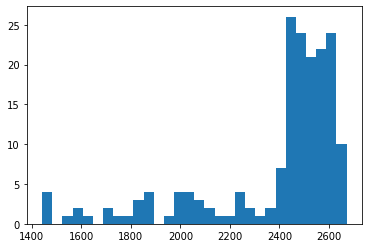

In [5]:
plt.hist(data, bins=30)

In [6]:
describe(data)

+--------------+-----------------------+
|    Field     |         Value         |
+--------------+-----------------------+
| Dataset name |           -           |
| Observations |          178          |
|     Mean     |   2383.844325842697   |
|    Median    |        2483.955       |
|   Maximum    |        2670.61        |
|   Minimum    |        1441.95        |
|  Std. Dev.   |   289.4910699654033   |
|   Skewness   |  -1.7010229235900562  |
|   Kurtosis   |    4.9966130843998    |
| Jarque-Bera  |   115.4061498504135   |
| Probability  | 8.707088749091896e-26 |
+--------------+-----------------------+


In [48]:
def describe_coefs(X, y, pred, coef, p, q):
    table = PrettyTable()
    N, k = X.shape
    res = y - pred
    RSS = res.T @ res
    sigma = RSS / (N - k)
    corr = np.linalg.inv(X.T @ X) * sigma
    corr = corr ** 0.5
    table.field_names = ["Variable", "Coefficient", "Std. Error", "t-Statistic", "Prob."]
    table.add_row(["Intercept", round(coef[0],5), round(corr[0][0],5),
                   round(coef[0] / corr[0][0],5), round(t.sf(abs(coef[0]) / corr[0][0], N-k),5)])
    for i in range(1, p + 1):
        err = corr[i][i]
        table.add_row(["a" + str(i), round(coef[i],5), round(err,5), round(coef[i] / err,5),
                       round(t.sf(abs(coef[i]) / err, N-k),5)])
    for i in range(p + 1, p + q + 1):
        err = corr[i][i]
        table.add_row(["b" + str(i - p), round(coef[i],5), round(err,5), round(coef[i] / err, 5)
                       , round(t.sf(abs(coef[i]) / err, N-k),5)])
    print(table)

In [8]:
def r2(y,y_pred): 
    return 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)

In [9]:
def adj_r2(r2, N, k):
    return 1 - (1 - r2) * (N - 1) / (N - k - 1)

In [10]:
def se(y, pred):
    return ((y - pred) ** 2).mean()

In [11]:
def rss(y, pred):
    return ((y - pred) ** 2).sum()

In [12]:
def llh(y, pred):
    N = len(y)
    resid = (y - pred)
    return - N / 2 * (1 + np.log(2*pi) + np.log((resid.T @ resid) / N))

In [13]:
def aic(l, N, k):
    return 2 / N * (k - l)

In [14]:
def schwarz(l, N, k):
    return (k * np.log(N) - 2 * l) / N

In [15]:
def F(r2_, N, k):
    return r2_ / (k - 1) / (1 - r2_) * (N - k)

In [16]:
def describe_model(y, pred, N, k):
    t = PrettyTable()
    t.field_names = ["Name", "Value"]
    r2_ = r2(y, pred)
    t.add_row(["R-squared", r2_])
    t.add_row(["Adjusted R-squared", adj_r2(r2_, N, k)])
    t.add_row(["S.E. of regression", se(y, pred)])
    t.add_row(["Sum squared resid", rss(y, pred)])
    l = llh(y, pred)
    t.add_row(["Log likelihood", l])
    t.add_row(["Durbin-Watson stat", DW(y - pred)])
    t.add_row(["Mean dependent var", pred.mean()])
    t.add_row(["S.D. dependent var", pred.std()])
    t.add_row(["Akaike info criterion", aic(l, N, k)])
    t.add_row(["Schwarz criterion", schwarz(l, N, k)])
    F_ = F(r2_, N, k)
    t.add_row(["F-statistic", F_])
    t.add_row(["Prob(F-statistic)", f.sf(F_, k - 1, N - k)])
    print(t)

In [78]:
def calc_corr(y, s = 12):
    t = PrettyTable()
    t.field_names = ["#", "AC", "PAC"]
    m = y.mean()
    var = np.sum((y - y.mean()) ** 2)
    N = len(y)
    r = [0]
    for i in range(1, s + 1):
        r.append(np.sum((y[i:] - m) * (y[:-i] - m)) / var)
    F = [[], [0, r[1]]]
    for k in range(1, s + 1):
        F.append([0])
        temp = r[k]
        for j in range(1, k):
            temp -= F[k - 1][j] * r[k - j]
        F_k = temp
        temp = 1
        for j in range(1, k):
            temp -= F[k - 1][j] * r[j]
        F_k /= temp
        for j in range(1, k):
            F[k].append(F[k - 1][j] - F_k * F[k - 1][k - j])
        F[k].append(F_k)
    for i in range(1, s + 1):
        t.add_row([i, r[i], F[i][i]])
    print(t)

In [18]:
def LS(X, y): 
    return list(np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)), X.T), y))

In [19]:
def movav(y, N):
    movav = [0 for x in range(N - 1)]
    for i in range(N - 1, len(y)):
        movav.append(y[i - (N - 1):i + 1].mean())
        #print(y[i - (N - 1):i + 1].mean())
        #print(movav[-1])
    return np.array(movav)

In [20]:
def movav_exp(y, N):
    movav = [0 for x in range(N - 1)]
    alpha = 2 / (N + 1)
    for i in range(N - 1, len(y)):
        temp = 0
        for j in range(N):
            temp += y[i - j] * (1 - alpha) ** (j + 1)
            #print(temp)
        movav.append(temp)
        #print("=",movav[-1])
    return np.array(movav)

In [21]:
def build_auto(y, movav, N, p, q):
    L = len(y)
    n = max(p, q+N-1)
    X = [np.ones(L - n)]
    for i in range(1, p + 1):
        X.append(y[n - i:L-i])
    for i in range(1, q + 1):
        X.append(movav[n - i:L - i])
    y1 = (y - movav)[n:]
    coefs = LS(np.array(X).T, y1)
    X.append(movav[n:])
    coefs.append(1)
    return np.array(X).T, y[n:], np.array(coefs)

In [22]:
def build_own(y, movav, N, p, q):
    alpha = 2 / (q + 1)
    b = np.array([(1 - alpha) ** j for j in range(1, q + 1)])
    b = b/np.sum(b) if q > 1 else b
    L = len(y)
    n = max(p, q+N-1)
    X = [np.ones(L - n)]
    y1 = (y - movav)[n:]
    for i in range(1, p + 1):
        X.append(y[n - i:L-i])
    for i in range(1, q + 1):
        y1 -= b[i - 1] *movav[n - i:L - i]
    X = np.array(X).T
    return X, y1, LS(X, y1)

In [23]:
def print_char(y, pred, k):
    t = PrettyTable()
    t.field_names = ["Name", "Value"]
    t.add_row(["R-squared", r2(y, pred)])
    t.add_row(["Sum squared resid", rss(y, pred)])
    t.add_row(["Akaike", aic(llh(y, pred), len(y), k)])
    t.add_row(["Durbin-Watson stat", DW(y - pred)])
    print(t)

(array([ 4.,  0.,  1.,  2.,  1.,  0.,  2.,  1.,  1.,  3.,  4.,  0.,  1.,
         4.,  4.,  3.,  2.,  1.,  1.,  4.,  2.,  1.,  2.,  7., 26., 24.,
        21., 22., 24., 10.]),
 array([1441.95      , 1482.90533333, 1523.86066667, 1564.816     ,
        1605.77133333, 1646.72666667, 1687.682     , 1728.63733333,
        1769.59266667, 1810.548     , 1851.50333333, 1892.45866667,
        1933.414     , 1974.36933333, 2015.32466667, 2056.28      ,
        2097.23533333, 2138.19066667, 2179.146     , 2220.10133333,
        2261.05666667, 2302.012     , 2342.96733333, 2383.92266667,
        2424.878     , 2465.83333333, 2506.78866667, 2547.744     ,
        2588.69933333, 2629.65466667, 2670.61      ]),
 <a list of 30 Patch objects>)

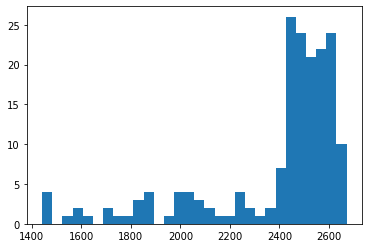

In [24]:
plt.hist(data, bins = 30)

In [25]:
describe(data, "rts2.txt")

+--------------+-----------------------+
|    Field     |         Value         |
+--------------+-----------------------+
| Dataset name |        rts2.txt       |
| Observations |          178          |
|     Mean     |   2383.844325842697   |
|    Median    |        2483.955       |
|   Maximum    |        2670.61        |
|   Minimum    |        1441.95        |
|  Std. Dev.   |   289.4910699654033   |
|   Skewness   |  -1.7010229235900562  |
|   Kurtosis   |    4.9966130843998    |
| Jarque-Bera  |   115.4061498504135   |
| Probability  | 8.707088749091896e-26 |
+--------------+-----------------------+


In [79]:
calc_corr(data)

+----+--------------------+-----------------------+
| #  |         AC         |          PAC          |
+----+--------------------+-----------------------+
| 1  | 0.9665656443133314 |   0.9665656443133314  |
| 2  | 0.9284375784580158 |  -0.08838769150943546 |
| 3  | 0.8888876263279988 | -0.036704264865053106 |
| 4  | 0.8500021586397086 | -0.008170501695976464 |
| 5  | 0.8138071340576104 |  0.019095860216682223 |
| 6  | 0.7784808603577844 | -0.012492671038138413 |
| 7  | 0.7426370692892226 | -0.030734065964901365 |
| 8  | 0.7074626688944252 | -0.008734902978573465 |
| 9  | 0.6772278167032693 |  0.05595312321822202  |
| 10 | 0.6501410220270479 |  0.02021084863904506  |
| 11 | 0.6226977319416506 |  -0.03202886981723008 |
| 12 | 0.5979066831919401 |  0.024625318586933755 |
+----+--------------------+-----------------------+


In [27]:
y =data

In [28]:
N = len(y)

In [29]:
X = np.array([np.ones(N - 1), y[:-1]]).T
y = y[1:]

In [30]:
coefs = LS(X, y)

In [31]:
coefs

[-64.05181011200318, 1.024067169513107]

In [32]:
pred = X @ coefs

In [33]:
res = y - pred

In [37]:
print_coefs(coefs, p, 0)
print_char(y, X @ coefs, p + 0 + 1)

NameError: name 'p' is not defined

In [76]:
calc_corr(res)

+----+------------------------+-----------------------+
| #  |           AC           |          PAC          |
+----+------------------------+-----------------------+
| 1  |  0.24959866204144618   |  0.24959866204144618  |
| 2  | -0.008824305185064302  |  -0.0758491615160661  |
| 3  | -0.0011461188067671386 |  0.021618791830574812 |
| 4  |  0.08909562385238053   |  0.08937802189361575  |
| 5  |  0.11729818375373832   |  0.07678622985474914  |
| 6  |  -0.04975419617074549  |  -0.10050392711344083 |
| 7  |  0.04242712798961295   |  0.09833788404087979  |
| 8  |  0.07241814770542382   |  0.02892186588238924  |
| 9  |  -0.10075703478159924  |  -0.15686342851086219 |
| 10 |  -0.07214407285094972  | 0.0027717513730221776 |
| 11 |  0.17107540683327696   |  0.22274863735009284  |
| 12 |  0.08120578265860558   |  -0.07349016316912024 |
+----+------------------------+-----------------------+


In [35]:
def print_coefs(coefs, p, q):
    t = PrettyTable()
    t.field_names = ["coef", "Value"]
    t.add_row(["a0", coefs[0]])
    equation = "y(k) = " + str(round(coefs[0],2))
    for i in range(p):
        t.add_row(["a" + str(i + 1), coefs[i + 1]])
        sign = " + " if (coefs[i + 1] >= 0) else " - "
        equation += sign + str(abs(round(coefs[i + 1], 2))) + "*y(k - " + str(i + 1) + ")"
    equation += " + ma(k)"
    for i in range(q):
        t.add_row(["b" + str(i + 1), coefs[i + p + 1]])
        sign = " + " if (coefs[i + p + 1] >= 0) else " - "
        equation += sign + str(abs(round(coefs[i + p + 1], 2))) + "*ma(k - " + str(i + 1) + ")"
    print(t)
    print(equation)

In [36]:
def print_coefs_own(coefs, p, q):
    t = PrettyTable()
    t.field_names = ["coef", "Value"]
    t.add_row(["a0", coefs[0]])
    equation = "y(k) = " + str(round(coefs[0],2))
    for i in range(p):
        t.add_row(["a" + str(i + 1), coefs[i + 1]])
        sign = " + " if (coefs[i + 1] >= 0) else " - "
        equation += sign + str(abs(round(coefs[i + 1], 2))) + "*y(k - " + str(i + 1) + ")"
    equation += " + ma(k)"
    alpha = 2 / (1 + q)
    b = np.array([(1 - alpha) ** j for j in range(1, q + 1)])
    b /= np.sum(b)
    for i in range(q):
        t.add_row(["b" + str(i + 1), b[i]])
        sign = " + " if (b[i] >= 0) else " - "
        equation += sign + str(abs(round(b[i],2))) + "*ma(k - " + str(i + 1) + ")"
    print(t)
    print(equation)

In [39]:
N = 5
q = 4
p = 1
movav_ = movav(res, N)
X_, y_, coefs = build_auto(y, movav_, N, p, q)
print_coefs(coefs, p, q)
print_char(y_, X_ @ coefs, p + q + 1)

+------+----------------------+
| coef |        Value         |
+------+----------------------+
|  a0  |  -56.73372329164147  |
|  a1  |  1.021232729484551   |
|  b1  | 0.019804517927956677 |
|  b2  |  -1.016738688588105  |
|  b3  | 0.056943789449351634 |
|  b4  |  0.535422437046269   |
+------+----------------------+
y(k) = -56.73 + 1.02*y(k - 1) + ma(k) + 0.02*ma(k - 1) - 1.02*ma(k - 2) + 0.06*ma(k - 3) + 0.54*ma(k - 4)
+--------------------+--------------------+
|        Name        |       Value        |
+--------------------+--------------------+
|     R-squared      | 0.9966580878775428 |
| Sum squared resid  | 48015.12711622641  |
|       Akaike       | 8.558255657141999  |
| Durbin-Watson stat | 1.919923184398006  |
+--------------------+--------------------+


In [40]:
N = 10
movav_ = movav(res, N)
X_, y_, coefs = build_auto(y, movav_, N, p, q)
print_coefs(coefs, p, q)
print_char(y_, X_ @ coefs, p + q + 1)

+------+----------------------+
| coef |        Value         |
+------+----------------------+
|  a0  |  -63.02674769936772  |
|  a1  |  1.0239804734664144  |
|  b1  | -0.8351530994086787  |
|  b2  | -0.3588721622186597  |
|  b3  |  0.6830511392748928  |
|  b4  | -0.16934469985820577 |
+------+----------------------+
y(k) = -63.03 + 1.02*y(k - 1) + ma(k) - 0.84*ma(k - 1) - 0.36*ma(k - 2) + 0.68*ma(k - 3) - 0.17*ma(k - 4)
+--------------------+--------------------+
|        Name        |       Value        |
+--------------------+--------------------+
|     R-squared      | 0.9962996932840369 |
| Sum squared resid  | 53077.26020809209  |
|       Akaike       |  8.69068524113086  |
| Durbin-Watson stat | 1.5965168117765012 |
+--------------------+--------------------+


In [41]:
N = 5
movav_ = movav_exp(res, N)
X_, y_, coefs = build_auto(y, movav_, N, p, q)
print_coefs(coefs, p, q)
print_char(y_, X_ @ coefs, p + q+1)

+------+-----------------------+
| coef |         Value         |
+------+-----------------------+
|  a0  |   -62.11456594997486  |
|  a1  |   1.0233547676912158  |
|  b1  |  -0.5181912272673728  |
|  b2  |  -0.13886676191353875 |
|  b3  | -0.014768908745465215 |
|  b4  |   0.1324725413607395  |
+------+-----------------------+
y(k) = -62.11 + 1.02*y(k - 1) + ma(k) - 0.52*ma(k - 1) - 0.14*ma(k - 2) - 0.01*ma(k - 3) + 0.13*ma(k - 4)
+--------------------+--------------------+
|        Name        |       Value        |
+--------------------+--------------------+
|     R-squared      | 0.9994269871152607 |
| Sum squared resid  | 8232.797719337625  |
|       Akaike       | 6.7948654461464075 |
| Durbin-Watson stat | 2.1625066407271745 |
+--------------------+--------------------+


In [42]:
N = 10
movav_ = movav_exp(res, N)
X_, y_, coefs = build_auto(y, movav_, N, p, q)
print_coefs(coefs, p, q)
print_char(y_, X_ @ coefs, p + q + 1)

+------+------------------------+
| coef |         Value          |
+------+------------------------+
|  a0  |    -64.49569773734     |
|  a1  |    1.0243066425578     |
|  b1  |  -0.8118768625187087   |
|  b2  | -0.0007462932007058498 |
|  b3  |  0.008544467988472526  |
|  b4  |  0.019436950680144616  |
+------+------------------------+
y(k) = -64.5 + 1.02*y(k - 1) + ma(k) - 0.81*ma(k - 1) - 0.0*ma(k - 2) + 0.01*ma(k - 3) + 0.02*ma(k - 4)
+--------------------+--------------------+
|        Name        |       Value        |
+--------------------+--------------------+
|     R-squared      | 0.9998125712127899 |
| Sum squared resid  | 2688.481597030712  |
|       Akaike       | 5.707913221449293  |
| Durbin-Watson stat | 1.6345441159688272 |
+--------------------+--------------------+


In [54]:
y = data
N = 10
movav_ = movav_exp(y, N)
calc_corr(movav_)

+----+--------------------+-----------------------+
| #  |         AC         |          PAC          |
+----+--------------------+-----------------------+
| 1  | 0.9680958773136839 |   0.9680958773136839  |
| 2  | 0.934266214969866  |  -0.0468768155490143  |
| 3  | 0.8986344690386644 | -0.045356934145069694 |
| 4  | 0.861575613140944  |  -0.03999243249427611 |
| 5  | 0.8232771695841989 | -0.037836271296654844 |
| 6  | 0.7839052471793999 |   -0.036131008692409  |
| 7  | 0.7438153167110932 |  -0.03144711493690663 |
| 8  | 0.7032272790042772 |  -0.02901633938437511 |
| 9  | 0.662013522998176  |  -0.03219767637949797 |
| 10 | 0.6482113967044546 |   0.4183982131193352  |
| 11 | 0.6345268286754527 |  -0.03788925861574155 |
| 12 | 0.6212590893945531 | -0.029577304274927354 |
+----+--------------------+-----------------------+


In [55]:
q = 10

In [56]:
X_, y_, coefs = build_auto(y, movav_, N, p, q)
print_coefs(coefs, p, q)
print_char(y_, X_ @ coefs, q +p +1)

+------+----------------------+
| coef |        Value         |
+------+----------------------+
|  a0  |  1.4804984859746728  |
|  a1  |   0.50380224549669   |
|  b1  | -1.1940974130143562  |
|  b2  | 0.29853830670931014  |
|  b3  | -0.00695332725776332 |
|  b4  | -0.02147658175097078 |
|  b5  | 0.07494028430098609  |
|  b6  | -0.05557880260588988 |
|  b7  | 0.004923488842830892 |
|  b8  | 0.027395525155075262 |
|  b9  | 0.055345384319560154 |
| b10  | -0.05655411378558606 |
+------+----------------------+
y(k) = 1.48 + 0.5*y(k - 1) + ma(k) - 1.19*ma(k - 1) + 0.3*ma(k - 2) - 0.01*ma(k - 3) - 0.02*ma(k - 4) + 0.07*ma(k - 5) - 0.06*ma(k - 6) + 0.0*ma(k - 7) + 0.03*ma(k - 8) + 0.06*ma(k - 9) - 0.06*ma(k - 10)
+--------------------+--------------------+
|        Name        |       Value        |
+--------------------+--------------------+
|     R-squared      | 0.9991095165645092 |
| Sum squared resid  | 1590.156602910978  |
|       Akaike       | 4.866175753366166  |
| Durbin-Watson stat

In [46]:
X_, y_, coefs = build_own(y, movav_, N, p, q)
print_coefs_own(coefs, p, q)
print_char(y_, X_ @ coefs, q + p + 1)

+------+----------------------+
| coef |        Value         |
+------+----------------------+
|  a0  | -2720.1767340875385  |
|  a1  |  -5.71963861776291   |
|  b1  | 0.21005616499078725  |
|  b2  | 0.17186413499246228  |
|  b3  |  0.1406161104483782  |
|  b4  | 0.11504954491230944  |
|  b5  | 0.09413144583734408  |
|  b6  | 0.07701663750328151  |
|  b7  | 0.06301361250268488  |
|  b8  | 0.051556592047651256 |
|  b9  | 0.04218266622080557  |
| b10  | 0.034513090544295466 |
+------+----------------------+
y(k) = -2720.18 - 5.72*y(k - 1) + ma(k) + 0.21*ma(k - 1) + 0.17*ma(k - 2) + 0.14*ma(k - 3) + 0.12*ma(k - 4) + 0.09*ma(k - 5) + 0.08*ma(k - 6) + 0.06*ma(k - 7) + 0.05*ma(k - 8) + 0.04*ma(k - 9) + 0.03*ma(k - 10)
+--------------------+---------------------+
|        Name        |        Value        |
+--------------------+---------------------+
|     R-squared      |  0.981462148804665  |
| Sum squared resid  |  8355014.277171446  |
|       Akaike       |  13.858288689243349 |
| Durbi

In [57]:
describe_coefs(X_, y_, X_ @ coefs, coefs, 1, q)

+-----------+-------------+------------+-------------+---------+
|  Variable | Coefficient | Std. Error | t-Statistic |  Prob.  |
+-----------+-------------+------------+-------------+---------+
| Intercept |    1.4805   |  0.85427   |   1.73307   | 0.04225 |
|     a1    |    0.5038   |  0.12068   |   4.17453   |  2e-05  |
|     b1    |   -1.1941   |  0.15017   |   -7.95149  |   0.0   |
|     b2    |   0.29854   |  0.12597   |   2.36996   | 0.00933 |
|     b3    |   -0.00695  |  0.03935   |   -0.17672  | 0.42995 |
|     b4    |   -0.02148  |  0.03946   |   -0.54428  |  0.2934 |
|     b5    |   0.07494   |  0.04008   |   1.86983   | 0.03142 |
|     b6    |   -0.05558  |  0.03952   |   -1.40646  |  0.0805 |
|     b7    |   0.00492   |   0.0395   |   0.12466   | 0.45045 |
|     b8    |    0.0274   |  0.03973   |   0.68949   | 0.24562 |
|     b9    |   0.05535   |  0.03672   |   1.50722   |  0.0666 |
|    b10    |   -0.05655  |  0.01701   |   -3.32481  | 0.00052 |
+-----------+------------

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


In [253]:
describe_model(y_, X_ @ coefs, len(y), X_.shape[1])

+-----------------------+---------------------+
|          Name         |        Value        |
+-----------------------+---------------------+
|       R-squared       |  0.999893965618921  |
|   Adjusted R-squared  |  0.9998886193476061 |
|   S.E. of regression  |  6.854123288409397  |
|   Sum squared resid   |  1590.1566029109802 |
|     Log likelihood    |  -552.4763873904753 |
|   Durbin-Watson stat  |  2.1133456875931897 |
|   Mean dependent var  | -1167.7271352653847 |
|   S.D. dependent var  |  254.23162700793478 |
| Akaike info criterion |  4.497819819844425  |
|   Schwarz criterion   |  4.666367370719252  |
|      F-statistic      |  204886.08193189272 |
|   Prob(F-statistic)   |         0.0         |
+-----------------------+---------------------+


In [58]:
datasets = ['RTScr', 'RTSeu', 'RTSfn', 'RTSin', 'RTSmm', 'RTSog', 'RTStl']

In [59]:
data = pd.DataFrame();

In [60]:
for dataset in datasets:
    temp = open('Data/' + dataset + '.txt', 'r').read()
    temp = np.array(list(map(float, re.findall(r"[-+]?\d*\.\d+|\d+", temp))))
    data[dataset] = temp

In [61]:
temp = open('Data/' + 'rts1' + '.txt', 'r').read()
temp = np.array(list(map(float, re.findall(r"[-+]?\d*\.\d+|\d+", temp))))
data['rts1'] = temp

In [62]:
corr_martix = data.corr()

In [63]:
corr_martix

,RTScr,RTSeu,RTSfn,RTSin,RTSmm,RTSog,RTStl,rts1
RTScr,1.000000,0.929083,0.960564,0.897707,0.851709,0.682340,0.956929,0.848433
RTSeu,0.929083,1.000000,0.878301,0.794041,0.697672,0.412473,0.887168,0.638377
RTSfn,0.960564,0.878301,1.000000,0.828220,0.808881,0.739310,0.925300,0.879438
RTSin,0.897707,0.794041,0.828220,1.000000,0.944448,0.726153,0.886036,0.859188
RTSmm,0.851709,0.697672,0.808881,0.944448,1.000000,0.841226,0.798230,0.928940
RTSog,0.682340,0.412473,0.739310,0.726153,0.841226,1.000000,0.667557,0.961389
RTStl,0.956929,0.887168,0.925300,0.886036,0.798230,0.667557,1.000000,0.822547
rts1,0.848433,0.638377,0.879438,0.859188,0.928940,0.961389,0.822547,1.000000


In [64]:
X = [np.ones(data.shape[0])]

In [65]:
for dataset in datasets:
    X.append(np.array(data[dataset]))

In [66]:
y = data['rts1']

In [67]:
X = np.array(X).T

In [68]:
coefs = LS(X, y)

In [69]:
print_coefs_own(coefs, 7, 0)
print_char(y, X @ coefs, 8)

+------+----------------------+
| coef |        Value         |
+------+----------------------+
|  a0  |  -59.26589977271351  |
|  a1  | -0.18567906619294128 |
|  a2  | 0.007907070106146663 |
|  a3  |  0.782037895850106   |
|  a4  | -0.11340168455664079 |
|  a5  |  1.249311344510304   |
|  a6  |  4.137006460659119   |
|  a7  |  0.6522650144380755  |
+------+----------------------+
y(k) = -59.27 - 0.19*y(k - 1) + 0.01*y(k - 2) + 0.78*y(k - 3) - 0.11*y(k - 4) + 1.25*y(k - 5) + 4.14*y(k - 6) + 0.65*y(k - 7) + ma(k)
+--------------------+--------------------+
|        Name        |       Value        |
+--------------------+--------------------+
|     R-squared      | 0.9992758712034502 |
| Sum squared resid  | 10773.325325558326 |
|       Akaike       | 7.030809637237396  |
| Durbin-Watson stat |        0.0         |
+--------------------+--------------------+


In [70]:
describe_coefs(X, y, X @ coefs, coefs, 7, 0)

+-----------+-------------+------------+-------------+---------+
|  Variable | Coefficient | Std. Error | t-Statistic |  Prob.  |
+-----------+-------------+------------+-------------+---------+
| Intercept |   -59.2659  |  12.02437  |   -4.92881  |   0.0   |
|     a1    |   -0.18568  |   0.1263   |   -1.47019  | 0.07168 |
|     a2    |   0.00791   |  0.05626   |   0.14055   |  0.4442 |
|     a3    |   0.78204   |  0.03802   |   20.56968  |   0.0   |
|     a4    |   -0.1134   |   0.0557   |   -2.0359   | 0.02166 |
|     a5    |   1.24931   |  0.06141   |   20.34322  |   0.0   |
|     a6    |   4.13701   |  0.07235   |   57.17853  |   0.0   |
|     a7    |   0.65227   |   0.0911   |   7.15985   |   0.0   |
+-----------+-------------+------------+-------------+---------+


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


In [392]:
describe_model(y, X @ coefs, len(y), X.shape[1])

+-----------------------+-------------------------+
|          Name         |          Value          |
+-----------------------+-------------------------+
|       R-squared       |    0.9992758712034502   |
|   Adjusted R-squared  |    0.9992415929172229   |
|   S.E. of regression  |    60.52429958178835    |
|   Sum squared resid   |    10773.325325558326   |
|     Log likelihood    |    -617.7420577141282   |
|   Durbin-Watson stat  |           0.0           |
|   Mean dependent var  |    2043.5373033714825   |
|   S.D. dependent var  |    289.0012208342786    |
| Akaike info criterion |    7.030809637237396    |
|   Schwarz criterion   |    7.1738111451156925   |
|      F-statistic      |    33513.55230766007    |
|   Prob(F-statistic)   | 2.5564256209161355e-263 |
+-----------------------+-------------------------+


## Искусство это взрыв! (творческая часть)

In [454]:
def PCF(y, x, s = 12):
    t = PrettyTable()
    t.field_names = ["#", "AC", "PAC"]
    r = [0]
    for i in range(1, s + 1):
        sigma1 = np.mean((y[i:] - y[i:].mean()) ** 2)
        sigma2 = np.mean((x[:-i] - x[:-i].mean()) ** 2)
        m1 = y[i:].mean()
        m2 = x[:-i].mean()
        r.append(np.mean((y[i:] - m1) * (x[:-i] - m2)) / np.sqrt(sigma1 * sigma2))
    F = [[], [0, r[1]]]
    for k in range(1, s + 1):
        F.append([0])
        temp = r[k]
        for j in range(1, k):
            temp -= F[k - 1][j] * r[k - j]
        F_k = temp
        temp = 1
        for j in range(1, k):
            temp -= F[k - 1][j] * r[j]
        F_k /= temp
        for j in range(1, k):
            F[k].append(F[k - 1][j] - F_k * F[k - 1][k - j])
        F[k].append(F_k)
    for i in range(1, s + 1):
        t.add_row([i, r[i], F[i][i]])
    print(t)

In [455]:
datasets = ['RTScr', 'RTSeu', 'RTSfn', 'RTSin', 'RTSmm', 'RTSog', 'RTStl']
data = pd.DataFrame()
for dataset in datasets:
    temp = open('Data/' + dataset + '.txt', 'r').read()
    temp = np.array(list(map(float, re.findall(r"[-+]?\d*\.\d+|\d+", temp))))
    data[dataset] = temp

In [456]:
temp = open('Data/' + 'rts1' + '.txt', 'r').read()
temp = np.array(list(map(float, re.findall(r"[-+]?\d*\.\d+|\d+", temp))))
data['rts1'] = temp

In [457]:
for dataset in datasets:
    print(dataset)
    PCF(np.array(data['rts1']), np.array(data[dataset]))

RTScr
+----+--------------------+----------------------+
| #  |         AC         |         PAC          |
+----+--------------------+----------------------+
| 1  |  0.83236718909945  |   0.83236718909945   |
| 2  | 0.8147470836038608 |  0.3968941796208944  |
| 3  | 0.7977268838450214 | 0.22551188465668656  |
| 4  | 0.7809733385865276 | 0.13463599794143144  |
| 5  | 0.7638051883193337 | 0.07868738631566911  |
| 6  | 0.7469403013999965 | 0.04589551549998157  |
| 7  | 0.7308865917037936 | 0.02860043628741469  |
| 8  | 0.7126541217670407 | 0.007278371631564438 |
| 9  | 0.698721069892005  | 0.014331635583663179 |
| 10 | 0.6876310537269482 | 0.025609245696473822 |
| 11 | 0.6794990460390008 | 0.03778312903111007  |
| 12 | 0.6670307066595718 |  0.0184361143787454  |
+----+--------------------+----------------------+
RTSeu
+----+---------------------+----------------------+
| #  |          AC         |         PAC          |
+----+---------------------+----------------------+
| 1  |  0.617880

In [458]:
orders = [3, 3, 3, 12, 5, 2, 3]

In [502]:
sum(orders)

31

In [459]:
calc_corr(data['rts1'])

+----+--------------------+----------------------+
| #  |         AC         |         PAC          |
+----+--------------------+----------------------+
| 1  | 0.9581272837420327 |  0.9581272837420327  |
| 2  | 0.8882927466260431 |  -0.362414699361081  |
| 3  | 0.8182060270813329 | 0.08280582907252257  |
| 4  | 0.7563500347563249 | 0.03316445489652662  |
| 5  | 0.7113684268302755 | 0.13651315333822409  |
| 6  | 0.6760401492820601 | -0.02411201602156806 |
| 7  | 0.6375305903200653 | -0.09240089062525238 |
| 8  | 0.6028254998248939 | 0.10430087117699804  |
| 9  | 0.5744360251983387 |  0.0391810383478796  |
| 10 | 0.5548016888604042 | 0.07439783217190306  |
| 11 | 0.5310596773964743 | -0.1631545975429465  |
| 12 | 0.5128905224537798 |  0.178841061747245   |
+----+--------------------+----------------------+


In [543]:
y = data['rts1']
N = 10
movav_ = movav_exp(y, N)
calc_corr(movav_)

+----+---------------------+-----------------------+
| #  |          AC         |          PAC          |
+----+---------------------+-----------------------+
| 1  |  0.9059474093250302 |   0.9059474093250302  |
| 2  |  0.8133398997861192 |  -0.04128549551405522 |
| 3  |  0.7218964703251192 |  -0.04450956118434974 |
| 4  |  0.6312744600810903 | -0.048421660938388435 |
| 5  |  0.5419679689762515 |  -0.0480797391453595  |
| 6  | 0.45316127642193427 |  -0.05498254015232495 |
| 7  | 0.36482309025215964 | -0.058364437663859785 |
| 8  | 0.27784562822231834 |  -0.05693743174550259 |
| 9  | 0.19145913712343948 |  -0.06459977993737097 |
| 10 | 0.19242851419617543 |   0.4258283650825356  |
| 11 |  0.1911365314157423 |  -0.03231030833878832 |
| 12 | 0.18914138559542007 | -0.023376098735896324 |
+----+---------------------+-----------------------+


In [544]:
p = 1
q = 10

In [545]:
L = len(y)
n = max(max(p, q+N-1), max(orders))
X = [np.ones(L - n)]
for dataset in datasets:
    X.append(np.array(data[dataset])[n:])
for i in range(1, q + 1):
    X.append(movav_[n - i:L - i])
for order, dataset in zip(orders, datasets):
    for j in range(1, order + 1):
        X.append(np.array(data[dataset])[n - j:L-j])
y1 = (y - movav_)[n:]
coefs = LS(np.array(X).T, y1)


In [546]:
X.append(movav_[n:])
coefs.append(1)

In [547]:
X = np.array(X).T
coefs = np.array(coefs)

In [548]:
y = y[n:]

In [549]:
describe_model(y, X @ coefs, len(y), X.shape[1])

+-----------------------+------------------------+
|          Name         |         Value          |
+-----------------------+------------------------+
|       R-squared       |   0.9999398249008261   |
|   Adjusted R-squared  |   0.999911966058616    |
|   S.E. of regression  |   5.435303088248277    |
|   Sum squared resid   |   864.2131910314761    |
|     Log likelihood    |   -360.1979919390582   |
|   Durbin-Watson stat  |          0.0           |
|   Mean dependent var  |   2036.8802466430886   |
|   S.D. dependent var  |   300.5350158464199    |
| Akaike info criterion |   5.159723169044758    |
|   Schwarz criterion   |   6.124787383579421    |
|      F-statistic      |   36964.72407293593    |
|   Prob(F-statistic)   | 4.997736350812646e-211 |
+-----------------------+------------------------+


In [550]:
table = PrettyTable()
N, k = X.shape
res = y - X @ coefs
RSS = res.T @ res
sigma = RSS / (N - k)
corr = np.linalg.inv(X.T @ X) * sigma


In [551]:
rss(y, X @ coefs)

864.2131910314761

In [552]:
X.shape

(159, 50)

In [553]:
corr = np.diagonal(corr)

In [554]:
coefs = np.array([round(x, 5) for x in coefs])

In [555]:
coefs

array([-3.71025e+00,  7.48200e-02,  8.93800e-02,  1.70800e-02,
       -3.19000e-03,  3.49670e-01,  8.29760e-01, -3.99000e-02,
       -8.48370e-01,  2.26890e-01, -1.59940e-01,  2.45600e-02,
       -2.36300e-02, -2.93500e-02,  5.13600e-02, -4.66500e-02,
        1.04890e-01, -4.88300e-02,  3.16600e-02, -5.18800e-02,
       -5.94700e-02, -1.30020e-01,  1.71600e-01, -1.07650e-01,
        1.33410e-01, -1.70680e-01,  3.82000e-03,  1.26300e-02,
       -2.66100e-02,  1.16550e-01, -2.20170e-01,  1.69580e-01,
       -9.23300e-02, -3.05200e-02, -2.42300e-02, -2.15010e-01,
        5.37420e-01, -1.53860e-01, -6.36100e-02, -1.58640e-01,
       -1.24630e-01, -6.96000e-03, -1.43590e-01,  1.50700e-01,
        3.27000e-02, -7.49150e-01,  3.09840e-01, -3.09490e-01,
        2.46500e-02,  1.00000e+00])

In [556]:
corr = np.array([round(x, 5) for x in corr])

In [557]:
corr

array([6.750538e+01, 1.654000e-02, 5.870000e-03, 3.840000e-03,
       8.260000e-03, 7.300000e-03, 5.385000e-02, 1.769000e-02,
       1.261000e-02, 1.076000e-02, 3.170000e-03, 1.020000e-03,
       9.400000e-04, 6.000000e-04, 6.100000e-04, 6.400000e-04,
       4.900000e-04, 1.000000e-04, 2.632000e-02, 2.375000e-02,
       1.550000e-02, 1.346000e-02, 1.371000e-02, 5.620000e-03,
       6.730000e-03, 6.160000e-03, 2.640000e-03, 1.658000e-02,
       1.648000e-02, 1.713000e-02, 1.766000e-02, 1.718000e-02,
       1.731000e-02, 1.618000e-02, 1.692000e-02, 1.736000e-02,
       1.395000e-02, 1.559000e-02, 6.690000e-03, 1.584000e-02,
       1.635000e-02, 1.491000e-02, 1.355000e-02, 6.550000e-03,
       8.131000e-02, 4.483000e-02, 4.290000e-02, 5.045000e-02,
       2.494000e-02, 3.710000e-03])

In [563]:
equation = "rts1(k) = "

In [564]:
coef = coefs
table.field_names = ["Variable", "Coefficient", "Std. Error", "t-Statistic", "Prob."]
table.add_row(["Intercept", round(coef[0],5), round(corr[0],5),
               round(coef[0] / corr[0],5), round(t.sf(abs(coef[0]) / corr[0], N-k),5)])
equation += str(coef[0])
for j, dataset in enumerate(datasets):
    i = j + 1
    err = corr[i]**0.5
    equation += " + " if (coef[i] >=0) else " - "
    equation += str(abs(coef[i])) + "*"
    equation += dataset
    table.add_row([dataset, coef[i], err, coef[i] / err,
                   round(t.sf(abs(coef[i]) / err, N-k),5)])
equation += " + ma(k)"
for j in range(1, q + 1):
    i = len(datasets) + j + 1
    err = corr[i]**0.5
    equation += " + " if (coef[i] >=0) else " - "
    equation += str(abs(coef[i])) + "*"
    equation += "ma(k - " + str(j) + ")"
    table.add_row(["ma(-" +str(j) +")" , coef[i], err, coef[i] / err,
                   round(t.sf(abs(coef[i]) / err, N-k),5)])
i = len(datasets) + q + 1
for order, dataset in zip(orders, datasets):
    for j in range(1, order + 1):
        err = corr[i]**0.5
        equation += " + " if (coef[i] >=0) else " - "
        equation += str(abs(coef[i])) + "*"
        equation += dataset + "(k - " + str(j) + ")"
        table.add_row([dataset +"(-" + str(j) +")" , coef[i], err, coef[i] / err,
                   round(t.sf(abs(coef[i]) / err, N-k),5)])
        i += 1

print(table)

+------------+-------------+----------------------+-----------------------+---------+
|  Variable  | Coefficient |      Std. Error      |      t-Statistic      |  Prob.  |
+------------+-------------+----------------------+-----------------------+---------+
| Intercept  |   -3.71025  |       67.50538       |        -0.05496       | 0.47813 |
|   RTScr    |   0.07482   |  0.1286079313261822  |   0.5817681633509646  | 0.28096 |
|   RTSeu    |   0.08938   | 0.07661592523751182  |   1.166598193820921   | 0.12296 |
|   RTSfn    |   0.01708   | 0.06196773353931867  |   0.2756273148050945  | 0.39168 |
|   RTSin    |   -0.00319  | 0.09088454214001411  |  -0.03509947813881901 | 0.48603 |
|   RTSmm    |   0.34967   | 0.08544003745317531  |   4.092577794007097   |  4e-05  |
|   RTSog    |   0.82976   | 0.23205602771744585  |   3.5756881997925327  | 0.00026 |
|   RTStl    |   -0.0399   | 0.13300375934536587  |  -0.29999152051328987 | 0.38238 |
|   ma(-1)   |   0.22689   | 0.10373041983911951  |   

In [565]:
equation

'rts1(k) = -3.71025 + 0.07482*RTScr + 0.08938*RTSeu + 0.01708*RTSfn - 0.00319*RTSin + 0.34967*RTSmm + 0.82976*RTSog - 0.0399*RTStl + ma(k) + 0.22689*ma(k - 1) - 0.15994*ma(k - 2) + 0.02456*ma(k - 3) - 0.02363*ma(k - 4) - 0.02935*ma(k - 5) + 0.05136*ma(k - 6) - 0.04665*ma(k - 7) + 0.10489*ma(k - 8) - 0.04883*ma(k - 9) + 0.03166*ma(k - 10) + 0.03166*RTScr(k - 1) - 0.05188*RTScr(k - 2) - 0.05947*RTScr(k - 3) - 0.13002*RTSeu(k - 1) + 0.1716*RTSeu(k - 2) - 0.10765*RTSeu(k - 3) + 0.13341*RTSfn(k - 1) - 0.17068*RTSfn(k - 2) + 0.00382*RTSfn(k - 3) + 0.01263*RTSin(k - 1) - 0.02661*RTSin(k - 2) + 0.11655*RTSin(k - 3) - 0.22017*RTSin(k - 4) + 0.16958*RTSin(k - 5) - 0.09233*RTSin(k - 6) - 0.03052*RTSin(k - 7) - 0.02423*RTSin(k - 8) - 0.21501*RTSin(k - 9) + 0.53742*RTSin(k - 10) - 0.15386*RTSin(k - 11) - 0.06361*RTSin(k - 12) - 0.15864*RTSmm(k - 1) - 0.12463*RTSmm(k - 2) - 0.00696*RTSmm(k - 3) - 0.14359*RTSmm(k - 4) + 0.1507*RTSmm(k - 5) + 0.0327*RTSog(k - 1) - 0.74915*RTSog(k - 2) + 0.30984*RTStl(